Fake review detection with focus on word embedding techniques. 

In [1]:
#Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
import time
from sklearn.metrics import accuracy_score
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
#Seed used for all random operations in order to be able to replicate the experiment
seed = 3765

MODEL_NAMES = ["RandomForestClassifier", "AdaBoostClassifier", "KNearesNeighborsClassifier", "SVMClassifier", "MLPClassifier"]

In [3]:
bagOfWordsVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

Load the preprocessed dataset and then retirive the text data and labels as two separate dataframes. 

In [4]:
dataFrame = pd.read_csv('preprocessed_fake_reviews_dataset.csv')
dataFrame = dataFrame.dropna()
dataFrame['wordCount'] = dataFrame['reviewText'].apply(lambda x: len(x.split())).astype(str)
dataFrame = dataFrame.dropna()
dataFrame['punctuationCount'] = dataFrame['originText'].str.count(f'[{string.punctuation}]').astype(str)
dataFrame = dataFrame.dropna()
dataFrame = dataFrame.drop('Unnamed: 0', axis=1)

X = dataFrame['reviewText']
Y = dataFrame['label']

In [19]:
print("The loaded dataframe looks like this :)")
dataFrame.head()

The loaded dataframe looks like this :)


,category,rating,label,reviewText,type,originText,wordCount,punctuationCount
0,Home_and_Kitchen,5.0,CG,love well made sturdy comfortable love pretty,1,"Love this! Well made, sturdy, and very comfor...",7,5
1,Home_and_Kitchen,5.0,CG,love great upgrade original 've mine couple year,1,"love it, a great upgrade from the original. I...",8,3
2,Home_and_Kitchen,5.0,CG,pillow saved back love look feel pillow,1,This pillow saved my back. I love the look and...,7,2
3,Home_and_Kitchen,1.0,CG,missing information use great product price,1,"Missing information on how to use it, but it i...",6,2
4,Home_and_Kitchen,5.0,CG,nice set good quality set two month,1,Very nice set. Good quality. We have had the s...,7,2


Split up the data into training, testing and validation sets

In [6]:
trainData, testData, trainLabels, testLabels = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=seed, shuffle=True)

In [7]:
trainData.shape, testData.shape, trainLabels.shape, testLabels.shape

((32344,), (8087,), (32344,), (8087,))

In [8]:
validationData, trainData, validationLabels, trainLabels = train_test_split(trainData, trainLabels, train_size=0.1, random_state=seed, test_size=0.9, shuffle=True)

In [9]:
validationData.shape, trainData.shape, validationLabels.shape, trainLabels.shape

((3234,), (29110,), (3234,), (29110,))

Part 1 - Train and test several classifiers using two different word embedding techniques.

In [10]:
#Initialize the different classifiers
classifiersBagOfWords = {}
classifiersBagOfWords.update({"RandomForestClassifier": RandomForestClassifier()})
classifiersBagOfWords.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiersBagOfWords.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiersBagOfWords.update({"SVMClassifier": SVC()})
classifiersBagOfWords.update({"MLPClassifier": MLPClassifier()})

classifiersTFIDF = {}
classifiersTFIDF.update({"RandomForestClassifier": RandomForestClassifier()})
classifiersTFIDF.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiersTFIDF.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiersTFIDF.update({"SVMClassifier": SVC()})
classifiersTFIDF.update({"MLPClassifier": MLPClassifier()})

In [11]:
#Hyperparameters to optimize for each model
hyperParamLst = [
    {   #RandomForest
        'clf__n_estimators': [8,7,6,5,4,3,2,1],
        'clf__max_depth': [2,4,6,8,10,12,14,16]
    },


    {   #AdaBoost
        'clf__n_estimators': [10,20,30,40,50,60,70,75,80],
        'clf__learning_rate': [0.1,1,3,6,12,15,18,21,25]
    },

    {   #KNN
        'clf__n_neighbors': [1,3,5,7,10,12,13,14],
        'clf__p': [1,2]
    },

    {   #SVM
        'clf__kernel': ["linear", "poly", "rbf"],
        'clf__C': [0.1,2,3,5,7,10,12,14,16]
    },

    {   #MLP
        'clf__hidden_layer_sizes': [(4,2),(6,3),(6,4),(8,4),(10,5),(15,5),(15,10),(20,10),(30,15)],
        'clf__learning_rate': ["constant", "invscaling", "adaptive"]
    }
]

In [12]:
#Supress the warnings coming from sklearn
warnings.simplefilter("ignore")

#Optimize the hyperparameters of the different classifiers
optimalParamLstBagOfWords = []
optimalParamLstTFIDF = []
for keyClassifier, i in zip(classifiersBagOfWords, range(0, len(hyperParamLst))):
    pipelineBOW = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiersBagOfWords[keyClassifier])])
    pipelineTFIDF = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[keyClassifier])])

    gridSearchBOW = GridSearchCV(pipelineBOW, hyperParamLst[i], cv=3, scoring="accuracy")
    gridSearchBOW.fit(validationData, validationLabels)
    
    gridSearchTFIDF = GridSearchCV(pipelineTFIDF, hyperParamLst[i], cv=3, scoring="accuracy")
    gridSearchTFIDF.fit(validationData, validationLabels)

    print("Current Classifier:", keyClassifier)
    print("The optimal hyperparameters with 'bag of word' as vector representation: " + str(gridSearchBOW.best_params_) + ". This setup got the following accuracy: " + str(gridSearchBOW.best_score_ * 100) + "%")
    print("The optimal hyperparameters with 'TF-IDF' as vector representation: " + str(gridSearchTFIDF.best_params_) + ". This setup got the following accuracy: " + str(gridSearchTFIDF.best_score_ * 100) + "%")
    print("\n")

    optimalParamLstBagOfWords.append(gridSearchBOW.best_params_)
    optimalParamLstTFIDF.append(gridSearchTFIDF.best_params_)
    

Current Classifier: RandomForestClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__max_depth': 12, 'clf__n_estimators': 7}. This setup got the following accuracy: 68.8930117501546%
The optimal hyperparameters with 'TF-IDF' as vector representation: {'clf__max_depth': 12, 'clf__n_estimators': 8}. This setup got the following accuracy: 70.2226345083488%


Current Classifier: AdaBoostClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__learning_rate': 1, 'clf__n_estimators': 80}. This setup got the following accuracy: 74.64440321583177%
The optimal hyperparameters with 'TF-IDF' as vector representation: {'clf__learning_rate': 1, 'clf__n_estimators': 80}. This setup got the following accuracy: 75.20098948670379%


Current Classifier: KNeighborsClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__n_neighbors': 7, 'clf__p': 1}. This setup got the following accuracy: 62.21397649

In [13]:
dfModelsResult = pd.DataFrame(columns=["Classifier", "Vector Representation", "Training Time (minutes)", "Accuracy (%)", "f1 score"])

#Train and test the different classifiers
resultLstBOW = []
resultLstTFIDF = []
for keyClassifier, i in zip(classifiersBagOfWords, range(0, len(optimalParamLstBagOfWords))):
    pipelineBOW = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiersBagOfWords[keyClassifier])])
    pipelineBOW.set_params(**optimalParamLstBagOfWords[i])
    startTrainingTime = time.time()
    pipelineBOW.fit(trainData,trainLabels)
    stopTrainingTime = time.time()
    predictedLabels = pipelineBOW.predict(testData)

    row = {'Classifier': keyClassifier,
        'Vector Representation': "Bag of Words",
        "Training Time (minutes)": format(round((stopTrainingTime-startTrainingTime)/60,2)),
        "Accuracy (%)": np.mean(predictedLabels==testLabels)*100,
        "f1 score": f1_score(testLabels, predictedLabels, average="macro")
    }

    dfModelsResult = dfModelsResult.append(row, ignore_index=True)
    resultLstBOW.append(predictedLabels)

    pipelineTFIDF = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[keyClassifier])])
    pipelineTFIDF.set_params(**optimalParamLstTFIDF[i])
    startTrainingTime = time.time()
    pipelineTFIDF.fit(trainData, trainLabels)
    stopTrainingTime = time.time()
    predictedLabels = pipelineTFIDF.predict(testData)

    row = {'Classifier': keyClassifier,
        'Vector Representation': "TF-IDF",
        "Training Time (minutes)": format(round((stopTrainingTime-startTrainingTime)/60,2)),
        "Accuracy (%)": np.mean(predictedLabels==testLabels)*100,
        "f1 score": f1_score(testLabels, predictedLabels, average="macro")
    }

    dfModelsResult = dfModelsResult.append(row, ignore_index=True)
    resultLstTFIDF.append(predictedLabels)


Display the testing results

In [20]:
print("The following table shows the performance of the different classifiers")
dfModelsResult

The following table shows the performance of the different classifiers


,Classifier,Vector Representation,Training Time (minutes),Accuracy (%),f1 score
0,RandomForestClassifier,Bag of Words,0.02,68.344256,0.674159
1,RandomForestClassifier,TF-IDF,0.01,71.015210,0.709868
2,AdaBoostClassifier,Bag of Words,0.09,76.913565,0.768783
3,AdaBoostClassifier,TF-IDF,0.17,78.966242,0.789316
4,KNeighborsClassifier,Bag of Words,0.01,62.557191,0.612323
5,KNeighborsClassifier,TF-IDF,0.01,64.288364,0.614426
6,SVMClassifier,Bag of Words,2.51,86.558674,0.865586
7,SVMClassifier,TF-IDF,8.1,88.994683,0.889916
8,MLPClassifier,Bag of Words,2.53,82.243106,0.822315
9,MLPClassifier,TF-IDF,4.07,81.810313,0.817842


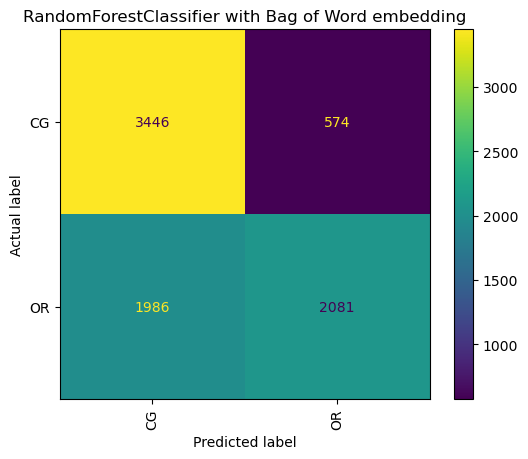

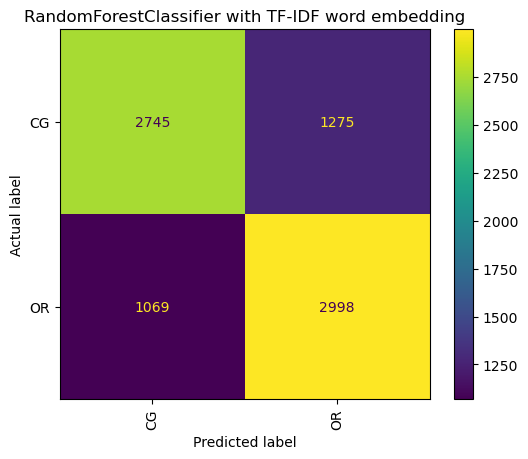

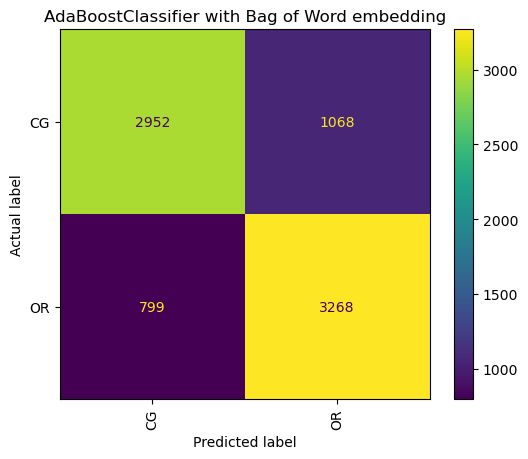

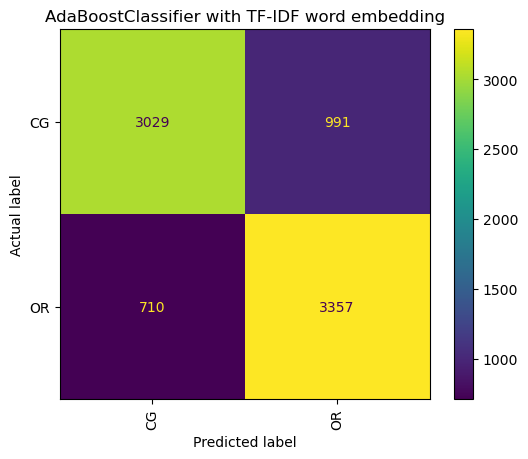

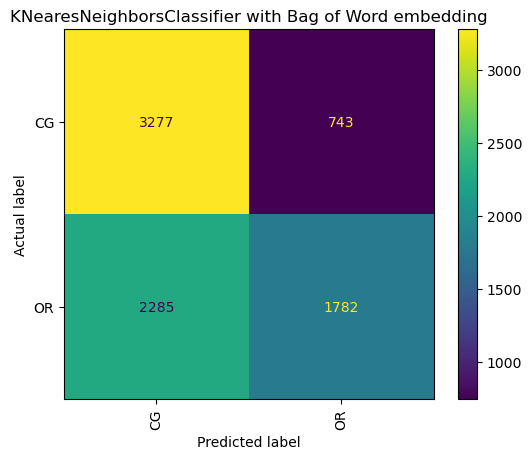

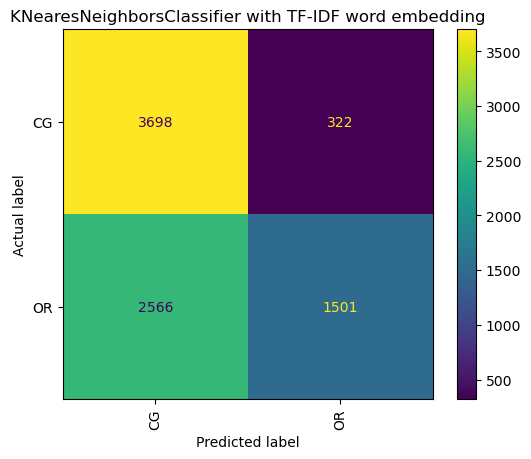

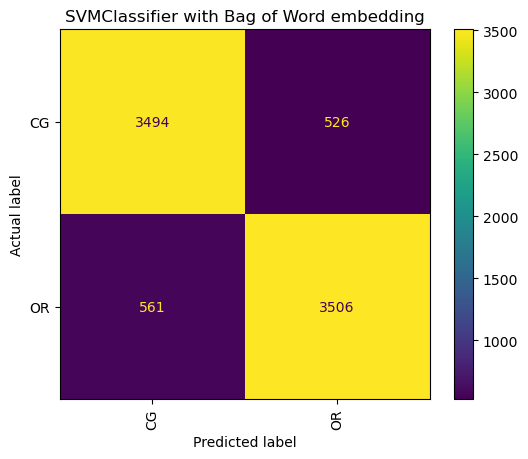

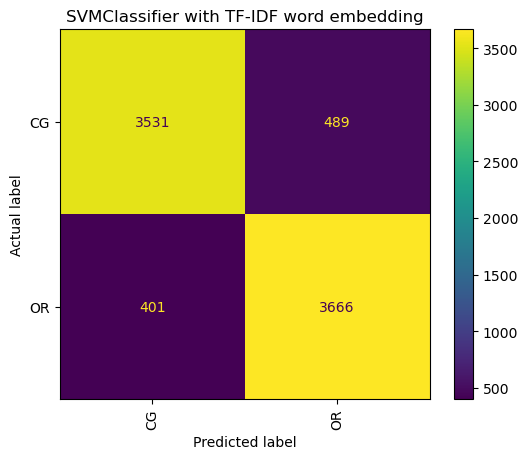

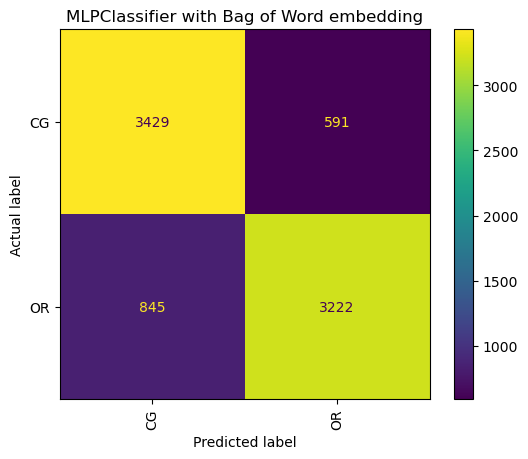

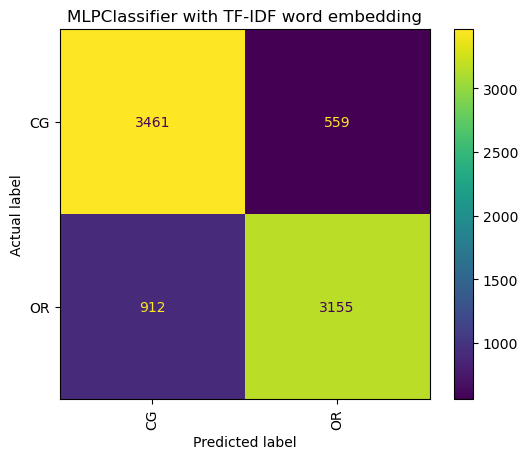

In [15]:
#Print the confusion matrices for each classifier
for i in range(0, len(resultLstTFIDF)):
    ConfusionMatrixDisplay.from_predictions(testLabels, resultLstBOW[i], xticks_rotation="vertical")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(str(MODEL_NAMES[i]) +" with Bag of Word embedding")
    plt.show()

    ConfusionMatrixDisplay.from_predictions(testLabels, resultLstTFIDF[i], xticks_rotation="vertical")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(str(MODEL_NAMES[i]) +" with TF-IDF word embedding")
    plt.show()


Part 2 - Trainig and predictions for several features using different word embedding techniques. In addition, using voting between the features and the classifiers for each feature in order to try and achieve better classification accuracy. 

In [16]:
def trainAndPredictForFeatures(features, vectorizer):
    
    warnings.simplefilter("ignore")
    
    predictions = []
    for feature in features:
        # Split the data into training and test sets
        trainData, testData, trainLabels, testLabels = train_test_split(dataFrame[feature], dataFrame['label'], test_size=0.20, random_state=seed, shuffle=True)
        validationData, trainData, validationLabels, trainLabels = train_test_split(trainData, trainLabels, train_size=0.1, test_size=0.9, shuffle=True, random_state=seed)

        classifiers = {}
        classifiers.update({"RandomForestClassifier": RandomForestClassifier()})
        classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
        classifiers.update({"KNeighborsClassifier": KNeighborsClassifier()})
        classifiers.update({"SVMClassifier": SVC()})
        classifiers.update({"MLPClassifier": MLPClassifier()})

        print("Now processing feature: ", feature)
        print("\n")
        print("Hyper parameter calculation phase")
        dataFrameModels = pd.DataFrame(columns=['model', 'run_time', "param_1", "param_2", 'acc_score'])
        bestParamLst = []
        for key, i in zip(classifiers, range(0, len(hyperParamLst))):
            pipeline = Pipeline([("vectorizer", vectorizer), ("clf", classifiers[key])])
            start_time = time.time()
            grid_search = GridSearchCV(pipeline, hyperParamLst[i], cv=3, scoring="accuracy")
            grid_search.fit(validationData, validationLabels)
            
            keys = list(grid_search.best_params_.keys())
            row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'param_1': grid_search.best_params_[keys[0]],
           'param_2':grid_search.best_params_[keys[1]],
           'acc_score': grid_search.best_score_
            }
            
            bestParamLst.append(grid_search.best_params_)

            dataFrameModels = dataFrameModels.append(row, ignore_index=True)
            
            
        display(dataFrameModels)

        print("\n")
        print("Classification phase")
        # Use optimal hyperparameters to get result of each classifier with them
        dataFrameModels = pd.DataFrame(columns=['model', 'run_time', 'acc'])
        resultLst = []
        for key, i in zip(classifiers, range(0,len(bestParamLst))):
            pipeline = Pipeline([("vectorizer", vectorizer), ("clf", classifiers[key])])
            start_time = time.time()
            pipeline.set_params(**bestParamLst[i])
            pipeline.fit(trainData, trainLabels)
            predictedLabels = pipeline.predict(testData)
            resultLst.append(predictedLabels)

            row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'acc': np.mean(predictedLabels == testLabels) * 100
            }

            dataFrameModels = dataFrameModels.append(row, ignore_index=True)
        display(dataFrameModels)

        # Use a voting approach to combine the predictions from the individual classifiers
        final_preds = []
        for i in range(len(resultLst[0])):
            # Count the number of times each label appears in the list of predictions
            counts = Counter([result[i] for result in resultLst])

            # Select the most common label as the final prediction
            final_preds.append(counts.most_common(1)[0][0])

        # Evaluate the performance of the combined classifiers
        final_accuracy = accuracy_score(testLabels, final_preds)
        print(f'Accuracy after vote of classifiers using feature {feature}: {final_accuracy * 100}')
        predictions.append(final_preds)
        print("\n")

    # Use a voting approach to combine the predictions from the individual features
    final_preds = []
    for i in range(len(predictions[0])):
        # Count the number of times each label appears in the list of predictions
        counts = Counter([result[i] for result in predictions])

        # Select the most common label as the final prediction
        final_preds.append(counts.most_common(1)[0][0])

    # Evaluate the performance of the combined classifiers
    final_accuracy = accuracy_score(testLabels, final_preds)
    print(f'Final accuracy after vote of features: {final_accuracy * 100}')

In [17]:
trainAndPredictForFeatures(["punctuationCount", "wordCount", "reviewText"], bagOfWordsVectorizer)

Now processing feature:  punctuationCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.07,16,8,0.524119
1,AdaBoostClassifier,0.6,1,60,0.526283
2,KNeighborsClassifier,0.05,13,1,0.499072
3,SVMClassifier,0.1,0.1,rbf,0.542672
4,MLPClassifier,1.2,"(20, 10)",constant,0.530303


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.0,52.145419
1,AdaBoostClassifier,0.03,53.517992
2,KNeighborsClassifier,0.03,52.615309
3,SVMClassifier,0.23,54.074440
4,MLPClassifier,0.07,53.814764


Accuracy after vote of classifiers using feature punctuationCount: 53.592184988252754
Now processing feature:  wordCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.06,16,8,0.530612
1,AdaBoostClassifier,0.57,1,80,0.532777
2,KNeighborsClassifier,0.05,1,1,0.530303
3,SVMClassifier,0.13,0.1,rbf,0.538343
4,MLPClassifier,1.52,"(6, 3)",adaptive,0.528448


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.0,51.922839
1,AdaBoostClassifier,0.03,54.507234
2,KNeighborsClassifier,0.02,49.585755
3,SVMClassifier,0.23,57.202918
4,MLPClassifier,0.06,56.831953


Accuracy after vote of classifiers using feature wordCount: 56.015827871893165
Now processing feature:  reviewText
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.33,16,8,0.691713
1,AdaBoostClassifier,1.09,1,80,0.740260
2,KNeighborsClassifier,0.14,1,2,0.609462
3,SVMClassifier,1.23,0.1,linear,0.793754
4,MLPClassifier,3.95,"(15, 10)",invscaling,0.789425


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.02,71.237789
1,AdaBoostClassifier,0.1,76.394213
2,KNeighborsClassifier,0.11,63.237294
3,SVMClassifier,2.78,86.509212
4,MLPClassifier,2.96,84.258687


Accuracy after vote of classifiers using feature reviewText: 84.46890070483491
Final accuracy after vote of features: 70.6566093730679


In [18]:
trainAndPredictForFeatures(["punctuationCount", "wordCount", "reviewText"], tfidfVectorizer)

Now processing feature:  punctuationCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.07,12,8,0.532158
1,AdaBoostClassifier,0.56,1,50,0.532777
2,KNeighborsClassifier,0.05,13,1,0.524119
3,SVMClassifier,0.1,0.1,rbf,0.541126
4,MLPClassifier,1.12,"(6, 3)",invscaling,0.533086


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.0,51.935205
1,AdaBoostClassifier,0.02,53.208854
2,KNeighborsClassifier,0.04,49.004575
3,SVMClassifier,0.22,54.062075
4,MLPClassifier,0.08,53.950785


Accuracy after vote of classifiers using feature punctuationCount: 53.431433164337825
Now processing feature:  wordCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.07,14,8,0.523810
1,AdaBoostClassifier,0.56,1,80,0.525046
2,KNeighborsClassifier,0.05,1,1,0.542672
3,SVMClassifier,0.12,0.1,rbf,0.551948
4,MLPClassifier,1.27,"(4, 2)",invscaling,0.536487


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.0,52.355632
1,AdaBoostClassifier,0.03,54.766910
2,KNeighborsClassifier,0.03,56.077655
3,SVMClassifier,0.22,57.314208
4,MLPClassifier,0.06,56.263138


Accuracy after vote of classifiers using feature wordCount: 56.36206256955608
Now processing feature:  reviewText
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.31,16,8,0.704082
1,AdaBoostClassifier,1.4,1,80,0.743661
2,KNeighborsClassifier,0.16,1,2,0.618429
3,SVMClassifier,1.54,2,rbf,0.820037
4,MLPClassifier,5.3,"(30, 15)",adaptive,0.805813


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.02,72.573266
1,AdaBoostClassifier,0.18,78.793125
2,KNeighborsClassifier,0.12,64.115247
3,SVMClassifier,8.25,88.920490
4,MLPClassifier,7.33,83.318907


Accuracy after vote of classifiers using feature reviewText: 86.60813651539507
Final accuracy after vote of features: 71.79423766538889
